In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Bernoulli = tf.contrib.distributions.Bernoulli
sg = tf.contrib.bayesflow.stochastic_graph
st = tf.contrib.bayesflow.stochastic_tensor
sge = tf.contrib.bayesflow.stochastic_gradient_estimators

In [3]:
data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [15]:
def add_layer(inputs, in_dim, out_dim):
    w = tf.Variable(tf.truncated_normal([in_dim, out_dim]))
    b = tf.Variable(tf.truncated_normal([1, out_dim]))
    return tf.add(tf.matmul(inputs, w), b)

def act_func(inputs, ST_1=False):
    r = tf.nn.sigmoid(inputs)
    if ST_1 is True:
        r = tf.stop_gradient(r-inputs) + inputs
    return r

def sample(inputs, GB=False, ST=True):
    eps = 1e-20
    if GB is False:
        inputs = tf.clip_by_value(inputs, 0.01, 0.99)
        ss = st.StochasticTensor(dist=Bernoulli(probs=inputs, dtype=tf.float32),
                                 dist_value_type=st.SampleValue(shape=[n_s]))          
        if ST is True:
            return tf.stop_gradient(ss.value()-inputs) + inputs
        return ss.value()
    else:
        g1 = tf.random_uniform(tf.shape(inputs), minval=0, maxval=1)
        g0 = tf.random_uniform(tf.shape(inputs), minval=0, maxval=1)
        p1 = tf.reshape(tf.log(inputs+eps) - tf.log(-tf.log(g1+eps)+eps), [-1,1])
        p0 = tf.reshape(tf.log(1.0-inputs+eps) - tf.log(-tf.log(g0+eps)+eps), [-1,1])
        p = tf.nn.softmax(tf.concat([p1, p0], 1))
        return [tf.reshape(p[:,1], tf.shape(inputs))]

def expect(inputs, y_):
    w = tf.Variable(tf.truncated_normal([200, 392]))
    b = tf.Variable(tf.truncated_normal([1, 392]))
    
    y = tf.add(tf.matmul(inputs[n_s-1], w), b)
    loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y), 1)
    vv = tf.square(loss)
    for i in range(n_s-1):
        yy = tf.add(tf.matmul(inputs[i], w), b)
        l_n = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=yy), 1)
        
        y = tf.add(yy, y)
        vv = tf.add(tf.square(l_n), vv)
        loss = tf.add(l_n, loss)
    return tf.nn.sigmoid(y/n_s), tf.reduce_mean(loss/n_s, keep_dims=True), tf.reduce_mean(vv/n_s-tf.square(loss/n_s))
    
def plt_figure(loss, lb=0, hb=500):
    plt.ylim(lb, hb)
    plt.plot(loss)
    plt.show()

In [16]:
lr = tf.constant(1e-3)
batch_size = 100
n_s = 1

LR = True
bl0 = tf.constant(0.0)
vr0 = tf.constant(0.0)
alpha = 0.9

NVIL = False
muProp = False

GB = False
ST = False
ST1 = False

In [17]:
x = tf.placeholder(tf.float32, [None, 392])
h1 = add_layer(x, 392, 200)
h1 = act_func(h1, ST1)
sh1 = sample(h1, GB, ST)

#h2 = add_layer(sh1, 200, 200)
#h2 = act_func(h2, ST1)
#sh2 = sample(h2, GB, ST)

w = tf.Variable(tf.truncated_normal([200, 392]))
b = tf.Variable(tf.truncated_normal([1, 392]))
y = tf.add(tf.matmul(sh1[0], w), b)

#y = add_layer(sh1[0], 200, 392)
y_ = tf.placeholder(tf.float32, [None, 392])
#y, loss, vv = expect(sh1, y_)

### train

In [14]:
loss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y), 1), keep_dims=True)

if LR is True:
    bl = alpha*bl0 + (1.0-alpha)*loss[0]
    vr = alpha*vr0 + (1.0-alpha)*tf.square(loss[0]-bl)
    f_loss = (loss-bl)/tf.maximum(1.0, tf.sqrt(vr))
    
    if NVIL is True:
        c = tf.nn.tanh(add_layer(sh1[0], 200, 100))
        cy = tf.nn.tanh(add_layer(c, 100, 1))
        f_loss = (loss-bl-cy)/tf.maximum(1.0, tf.sqrt(vr))
        c_loss = tf.square(loss-bl-cy)
        train_c = tf.train.AdamOptimizer(lr).minimize(c_loss) 
    if muProp is True:
        c = tf.add(tf.matmul(h1, w), b)
        fp = tf.gradients(c, h1)
        tf.stop_gradient(c)
        
        cv = tf.matmul(fp, h1)
        f_loss = loss-cv
        
    s_loss = sg.surrogate_loss([f_loss])
    train_step = tf.train.AdamOptimizer(lr).minimize(s_loss)
    
else:
    train_step = tf.train.AdamOptimizer(lr).minimize(loss)


ValueError: Shape must be rank 2 but is rank 3 for 'MatMul_8' (op: 'MatMul') with input shapes: [1,?,200], [?,200].

In [ ]:
ll = []
bll = 0.0
vrr = 0.0
lrr = 1e-3
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50000):
        batch_ = data.next_batch(batch_size)[0]
        batch_xs = batch_[:,0:392]
        batch_ys = batch_[:,392:784]
        
        if LR is True:
            if NVIL is True:
                _, l, bb, vv, _ = sess.run([train_step, loss, bl, vr, train_c], 
                                        {x: batch_xs, y_: batch_ys, bl0: bll, vr0: vrr, lr: lrr})
                if i==25000:
                    lrr = lrr*0.5
            else:
                _, l, bb, vv = sess.run([train_step, loss, bl, vr], 
                                        {x: batch_xs, y_: batch_ys, bl0: bll, vr0: vrr})
            bll = bb
            vrr = vv
        else:
            _, l = sess.run([train_step, loss], {x: batch_xs, y_: batch_ys})
            
        if i%1000==0:
            ll.append(l)
            print i/1000, l,

0 [ 1327.32775879] 1 [ 185.31019592] 2 [ 151.29667664] 3 [ 111.3625412] 4 [ 102.21103668] 5 [ 91.45200348] 6 [ 89.61453247] 7 [ 83.59388733] 8 [ 89.82754517] 9 [ 86.34511566] 10 [ 88.68067169] 11 [ 83.65467072] 12 [ 84.48816681] 13 [ 83.04508972] 14 [ 82.31710815] 15 [ 82.68902588] 16 [ 88.73682404] 17 [ 84.20585632] 18 [ 82.8078537] 19 [ 87.74578857] 20 [ 83.84065247] 21 [ 84.5652771] 22 [ 85.46533203] 23 [ 86.15072632] 24 [ 77.44434357] 25 [ 83.26213074] 26 [ 83.51963043] 27 [ 84.33542633] 28 [ 80.68336487] 29 [ 90.02470398] 30 [ 83.74704742] 31 [ 85.94761658] 32 [ 78.92725372] 33 [ 85.3460083] 34 [ 80.63465118] 35 [ 89.48175812] 36 [ 80.90447998] 37 [ 84.52322388] 38 [ 78.64797974] 39 [ 86.14650726] 40 [ 84.55577087] 41 [ 81.8327179] 42 [ 83.84104156] 43 [ 85.20449066]

### likelihood ratio

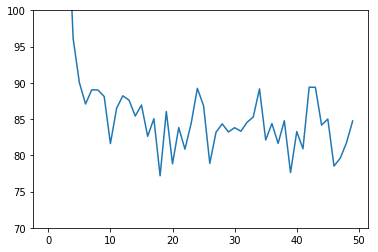

In [434]:
plt_figure(ll, 70, 100)

### no b no v

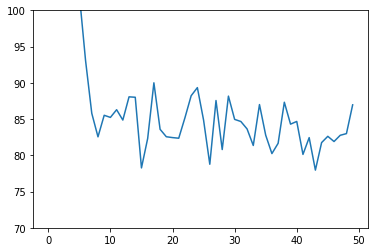

In [426]:
plt_figure(ll, 70, 100)

### baseline and var

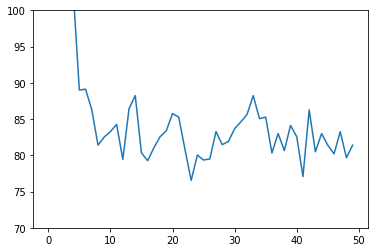

In [421]:
plt_figure(ll, 70, 100)

### gumbel softmax

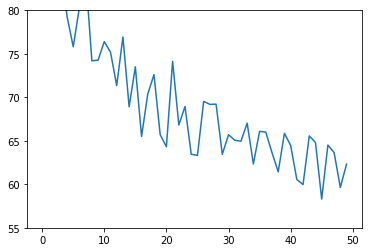

In [403]:
plt_figure(ll, 55, 80)

### stc with dsigm (ST)

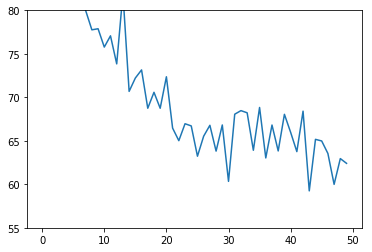

In [397]:
plt_figure(ll,55,80)

In [ ]:
aa = tf.Variable([[1.], [2.]])
bb = tf.concat([aa,aa], 0)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print sess.run(aa)
    r = sess.run(bb)
    print tf.reduce_sum(r, 1)
print r

In [ ]:
q3 = tf.Variable([[.5],[.5]])
q4 = st.StochasticTensor(dist=Bernoulli(probs=q3+1e-20))
q5 = tf.cast(q4, tf.float32)
ls = tf.concat([q5, q5], 0)
ls2 = tf.reduce_mean(tf.reduce_sum(ls,0), keep_dims=True)
qq = tf.Variable(2.)
ls2 = ls2 * qq
ls3 = sg.surrogate_loss([ls2])
tt = tf.train.AdamOptimizer(0.01).minimize(ls2)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(3):
        rr = sess.run([tt, ls3, ls2, q5, q3, qq])
        for i in rr:
            print i
        print


In [ ]:
a = tf.placeholder(tf.float32, [1,1])
b = tf.constant(2.)
aa = tf.add(a,b)
bb = 0.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in range(2):

        r = sess.run(aa,{a: [[1]], b: bb})
        bb = np.add(bb, r[0,0])
        print r

In [ ]:
ii = [[0.,0.],[1.,1.]]
qq = st.StochasticTensor(dist=Bernoulli(probs=ii, dtype=tf.float32), dist_value_type=st.SampleValue(shape=[1,2]))
loss = [2.] - qq.value()
with tf.Session() as sess:
    aa = sess.run(qq.value())
    print aa

In [ ]:
ii = tf.constant([[2.,2.],[1.,1.]])
aa = ii/2.
ww = tf.Session().run(aa)
print ww
    